<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/cluster_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Images

Clustering is a popular unsupervised learning algorithm often used in preprocessing data. To cluster similar items in the same group, two things are needed:

1. Features: Features are decided according to data types and purposes. Regardless of data type and features, they all need to be represented in vectors.
2. Distance functions: once the features are decided and converted into vector forms, you have to decide which distance function you want to use to measure the distance between two feature vectors. Popular distance functions are: Euclidean, Cosine, Manhattan, and Hamming.

In our case, the data types are images so we can use either pixel values or structures in images. For distance functions, we will try Euclidean and Cosine functions to compare the differences. 

# The Dataset
For the experiment, I downloaded twelve car images from [unsplash](https://unsplash.com/). Here is the breakdown:

- 1 Audi
- 3 Ferraris
- 8 Volkswagen Beetles

Ideally, we want to see Ferraris and Beetles to belong to their own clusters at least. One Audi is included to see if it belongs to which cluster. Visually, it looks similar to a Ferrari, but that is a subjective judgement.

In [ ]:
!git clone https://github.com/changsin/DLTrafficCounter

fatal: destination path 'DLTrafficCounter' already exists and is not an empty directory.


The sample data downloaded and resized to be included in this repository.

In [1]:
!git clone https://github.com/changsin/ClassifyImages

Cloning into 'ClassifyImages'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 144 (delta 55), reused 75 (delta 14), pack-reused 0
Receiving objects: 100% (144/144), 22.67 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (55/55), done.


## Load and visualize images
Let's first load and visualize the data.

In [1]:
import argparse
import glob
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist
from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

"""
Methods for loading and visualizing images
"""

IMAGE_SIZE = 320

def glob_files(folder, file_type='*'):
    search_string = os.path.join(folder, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths

def load_images(path, file_type="*"):
    files = glob_files(path, file_type)

    images = []
    for file in files:
        # print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            # normalize
            image = image / 256
            images.append(image)
        else:
            print(file, ' is not an image file')

    return np.array(images)

def plot_images(X, idx=None, limit=20):
  fig = plt.figure(figsize=(50,60))

  # The number of images for plotting is limited to 50
  end_id = len(X) if len(X) < limit else limit
  if idx is None:
    idx = range(0, end_id)

  i = 0
  for id in idx:
    axis = fig.add_subplot(5, 5, i+1)
    plt.axis('off')
    image = X[id]
    plt.imshow(image)
    i += 1

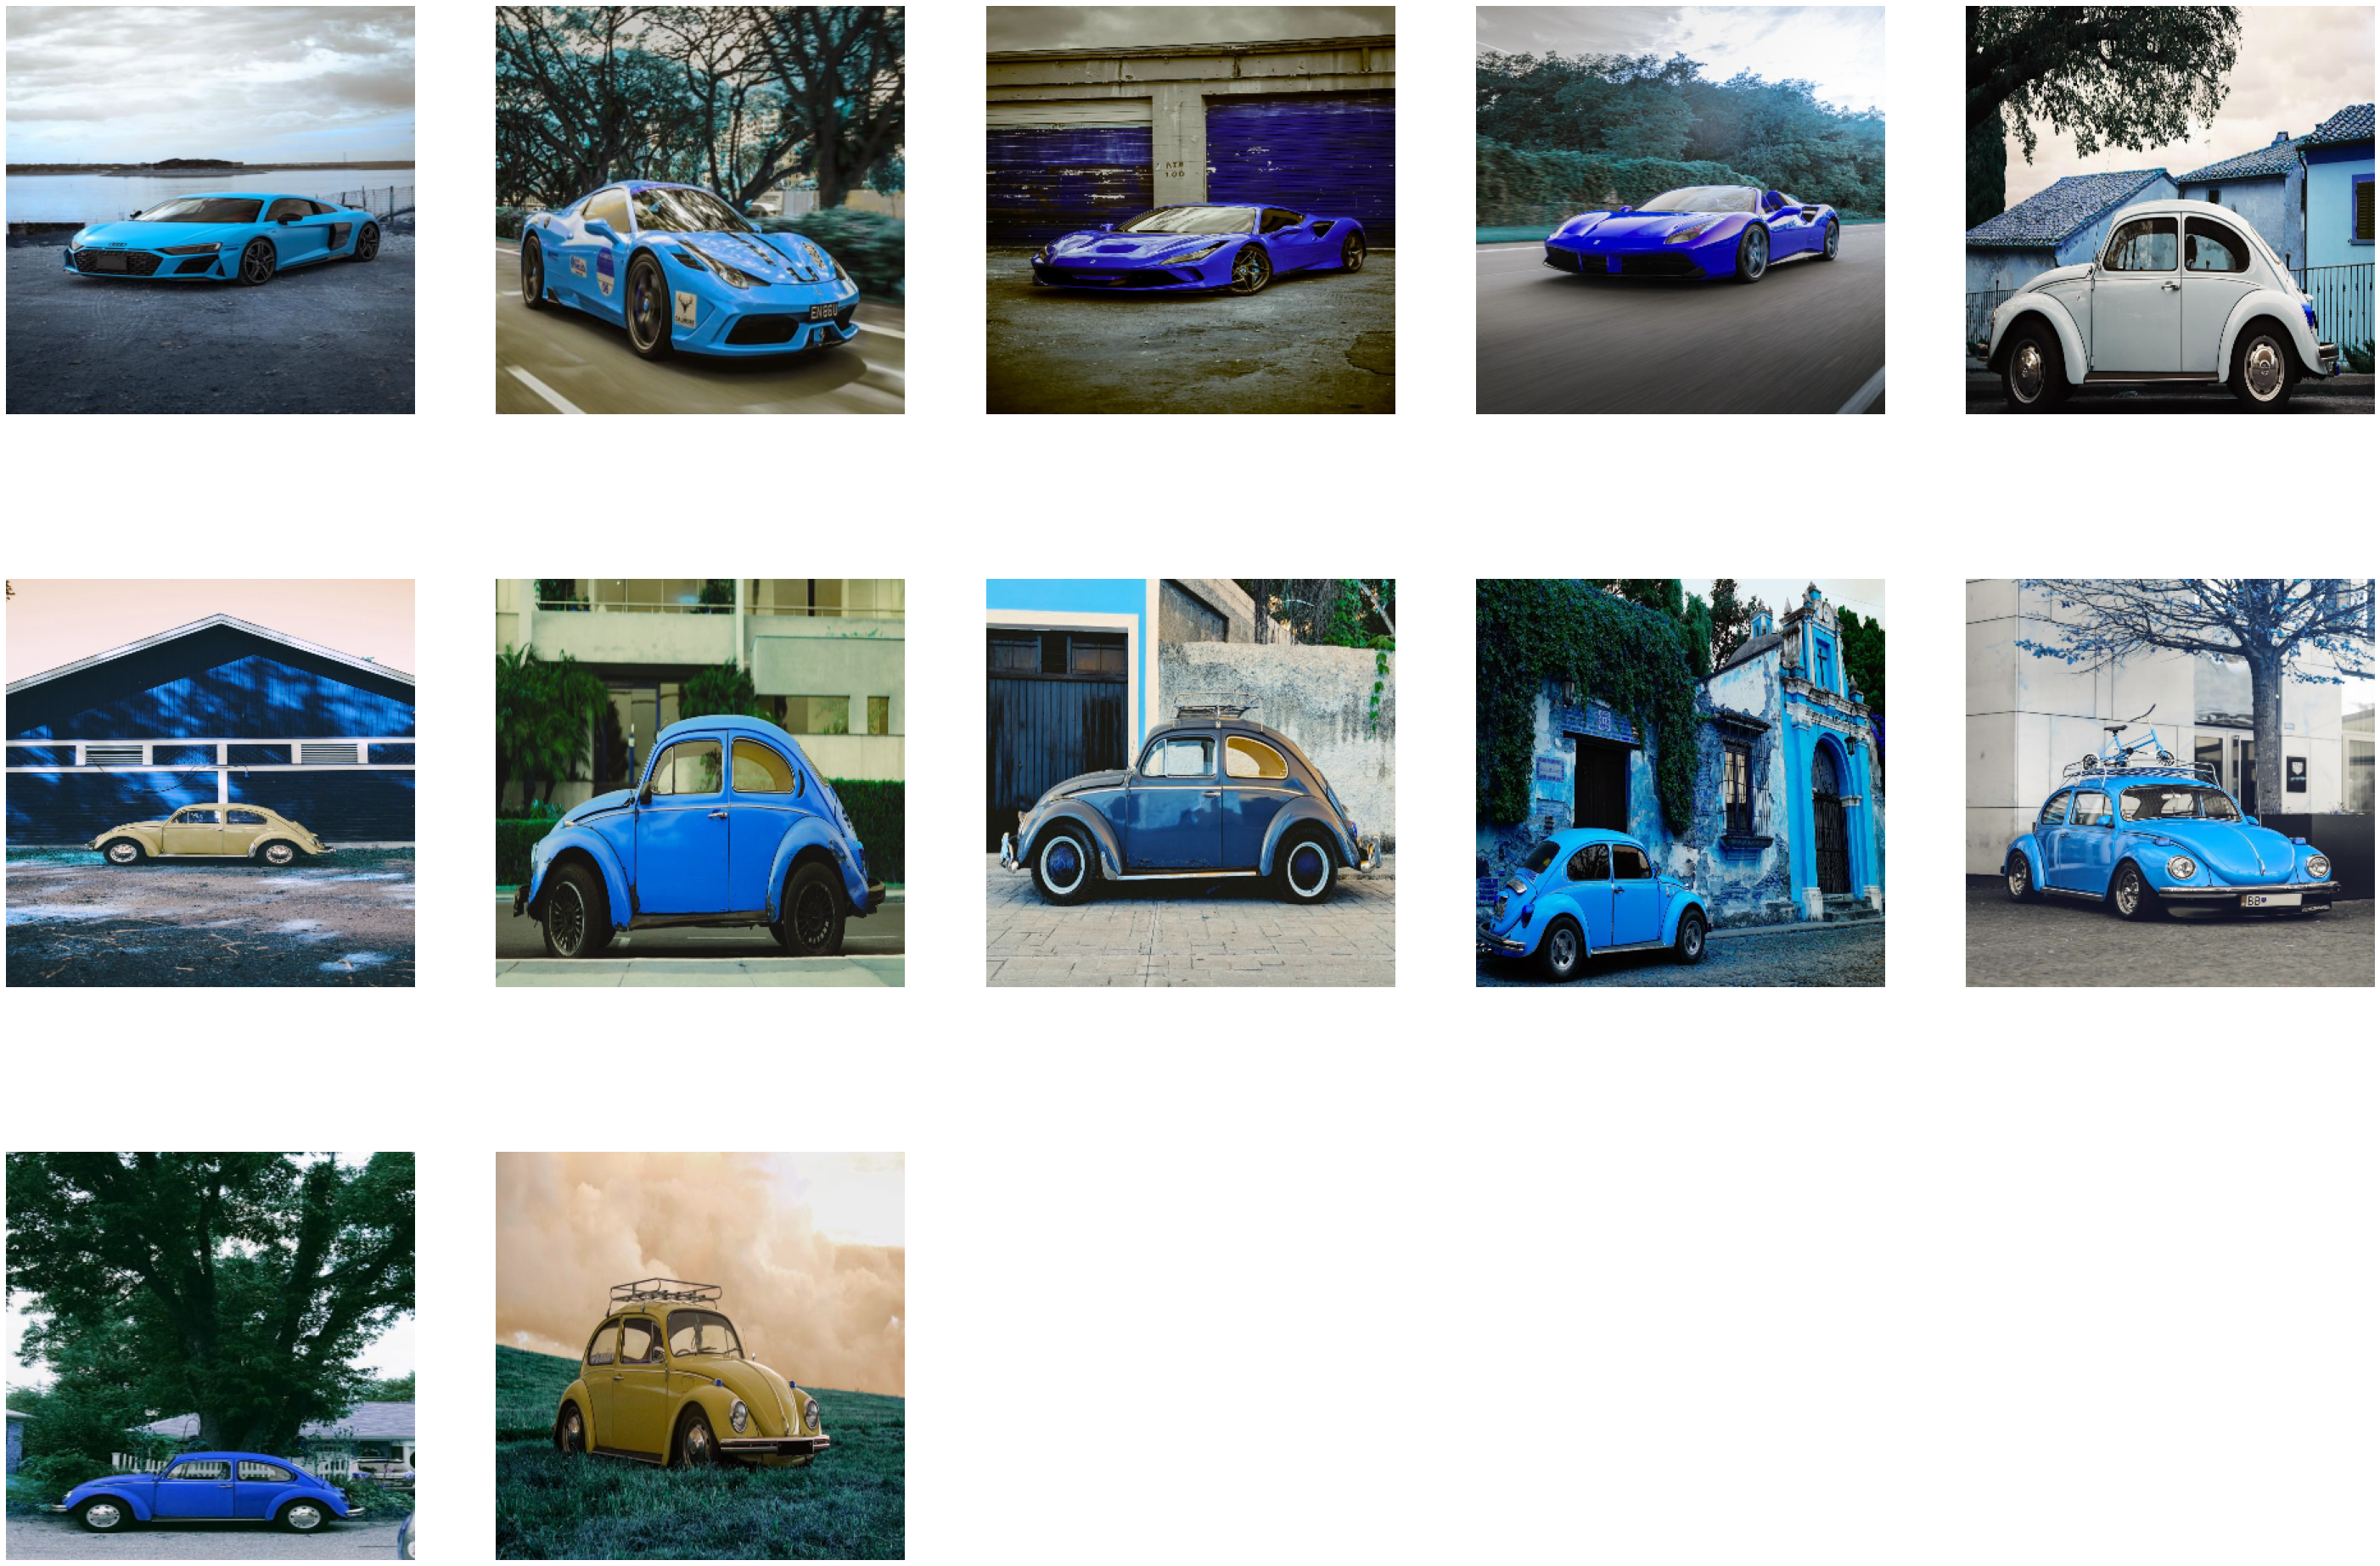

In [2]:
path_cars = '/content/ClassifyImages/data/cars'
images = load_images(path_cars)
images.shape
plot_images(images)

# Features

## Pixels as features
Let's first consider what the features should be. In other words, what do we want to use as feature vectors to run the clustering algorithm. Since the data type is image, they are loaded as multi-dimensional arrays already so the default choice is to use them as they are.

Running a clustering algorithm is easy with sklearn library which provides several clustering algorithms. Let's use KMeans which is probably the most popular. For visualization purposes, we will also run PCA (Principle Component Analysis) to reduce the dimension to two so that we can plot the clusters as x and y coordinates. Below is the implention.

```
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
```

In [3]:
def get_pca_reduced(X_features, dimensions=2):
  X_features_flatten = X_features.reshape(X_features.shape[0], -1)
  pca = PCA(dimensions)

  X_features_pca_reduced = pca.fit_transform(X_features_flatten)

  return X_features_pca_reduced, pca


def get_clusters(X_reduced, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X_reduced)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(path, K=2):
  X = load_images(path)
  plot_images(X)
  X_reduced, pca = get_pca_reduced(X, dimensions=K)

  X_clusters, kmeans = get_clusters(X_reduced, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  return X_reduced, kmeans

Here is the code for plotting the clusters.

In [44]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h * marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("K-means clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

[[-36.62040872  17.33850977]
 [146.48163487 -69.35403908]]
{0: array([0, 2, 3, 4]), 1: array([1])}


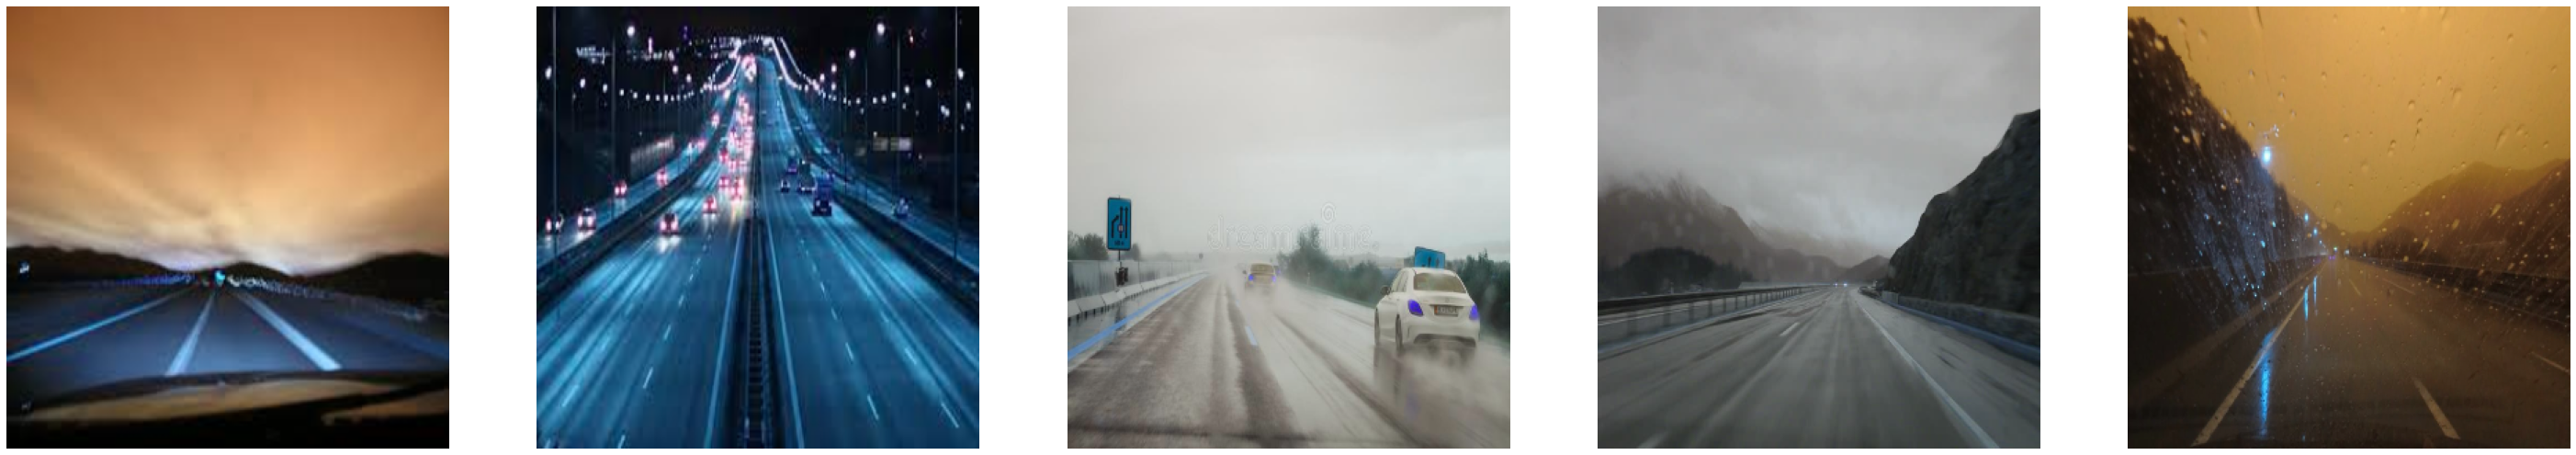

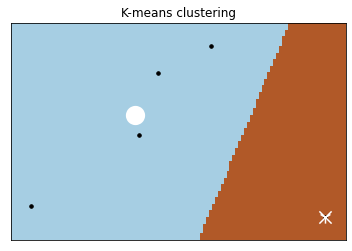

In [45]:
path_hiway = '/content/ClassifyImages/data/highway'
X_reduced_hi, kmeans_hi = cluster_images(path_hiway)
plot_data_in_clusters(X_reduced_hi, kmeans=kmeans_hi, idx=[1])

### Night and day images
Using pixels as feature vectors seems to have worked in this case. Instead of the car images, we used day and night images of hiway and the lone night image (the second image with index 1) was singled out as 'different' from other images. It is not hard to see why this happened. Daytime images tend to have bigger pixel values than nighttime images and thus the algorithm was able to find natural clusters.  


### Car images
What about our sample car images? Let's run the same algorithm to see what happens.

In [ ]:
X_reduced_cars, kmeans_cars = cluster_images(path_cars)
plot_data_in_clusters(X_reduced_cars, kmeans=kmeans_cars)

In [ ]:
plot_images(images, idx=[0,  3,  4,  5,  9, 11])

In [ ]:
plot_images(images, idx=[1,  2,  6,  7,  8, 10])

What happened? Though the algorithm ran without any error, the data points are scattered quite randomly around the latent space. What we wished to see some natural clusters instead. The reason should be obvious. In the day and night images, we were lucky because the magnitude of individual pixel values served as the pivoting criterion. In the case of cars, they were all taken during the day against complex backgrounds. Though we as humans could recognize different car model types, for the computers, they are just random pixel values and thus no natural clustering groups emerged.

What we need is a way for the machines to recognize structures inherent in images. For this, we are turning to CNN (Convolutional Neural Network). 


## CNN for feature maps
CNN is widely used to analyze images. An image is passed through a series of convolutions which act as filters to extract "feature maps." These feature maps are used as the input to the subsequent layers in the model to perform higher level cognition tasks such as object detection. Here is the diagram of VGG-16 which is one of the earliest CNN models.


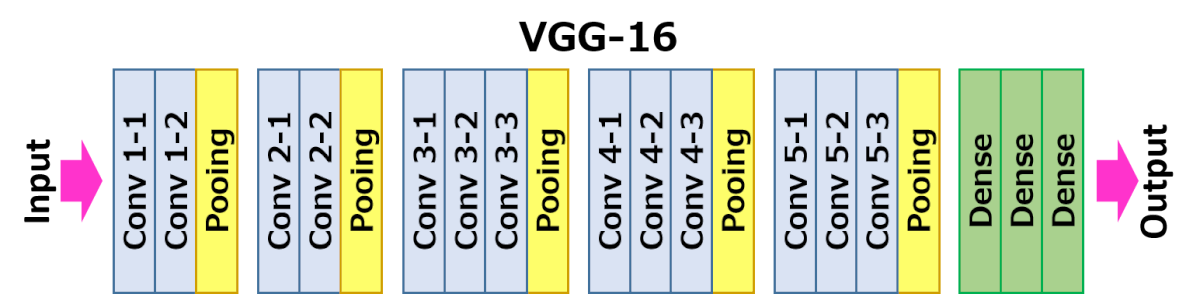

[image source](https://neurohive.io/en/popular-networks/vgg16/)

The convolutional layers comprise the majority of VGG-16 layers except the last three. To see the effect of convolutions. Let's intercept one of the convolution outputs and visualize them. Here is the method to intercept the CNN output. You can specify the layer number from which you want to extract the CNN output. 

In [47]:
def get_cnn_output(X, layer=1):
  """
  returns the CNN output from the specified layer
  """
  #Convert to VGG input format
  X = preprocess_input(X)

  #include_top=False == not getting VGG16 last 3 layers
  model = VGG16(weights="imagenet", include_top=False)

  model = Model(inputs=model.inputs, outputs=model.layers[layer].output)
  model.summary()
  features = model.predict(X)
  # print(features.shape)

  return features

In [48]:
cnn_results = get_cnn_output(images)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


It returns output vectors of size 64, each of which represents the result of a particular convolution. Let's take a look at a couple of them. Some outputs are not quite humanly recognizable, but here are a few that seem to make sense to a human eye. 

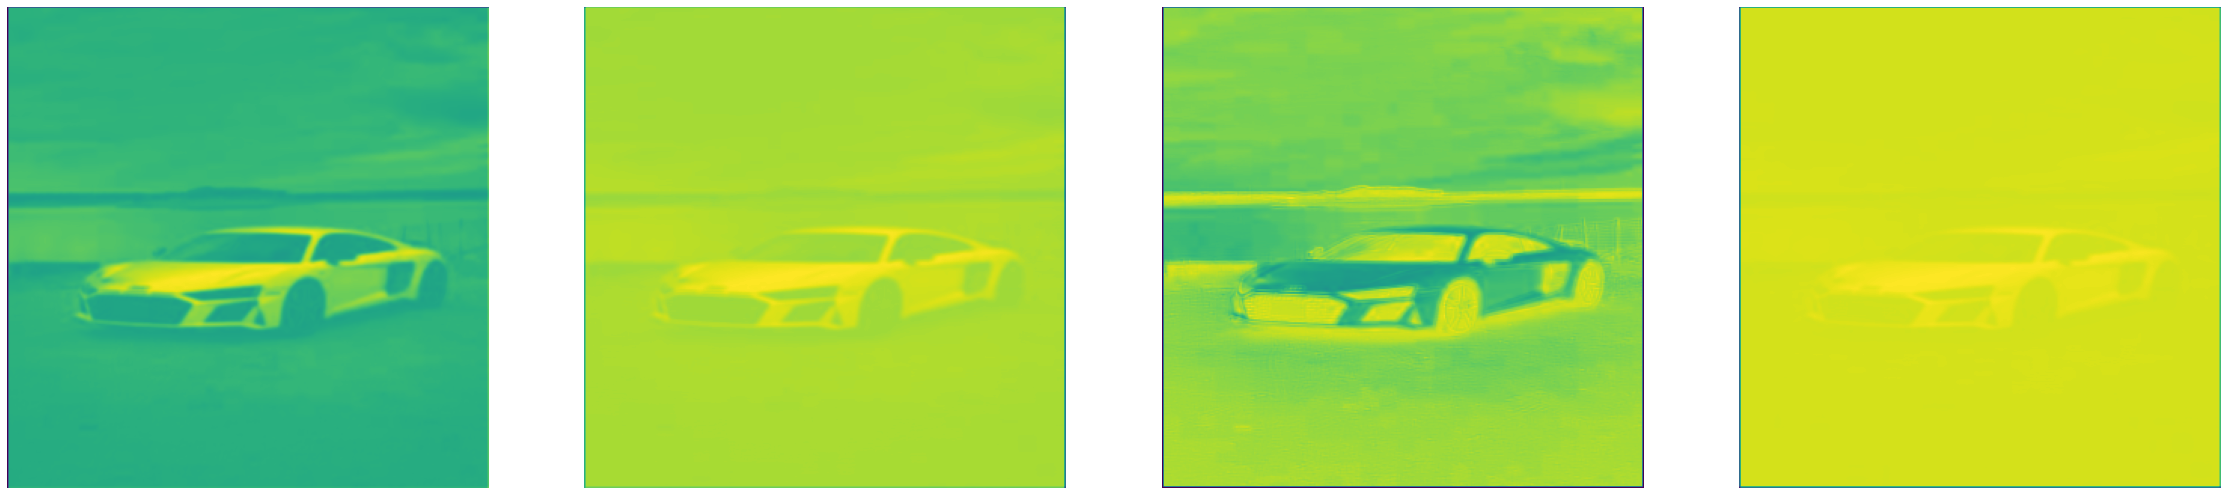

In [49]:
plot_images([cnn_results[0][:, :, 1], cnn_results[0][:, :, 22], cnn_results[0][:, :, 27], cnn_results[0][:, :, 50]])

We can see that each convolution operation is picking up particular aspect of the input image though we could not articulate exactly what they are. We visualized the output results from the first convolutional layer. The results are then fed into subsequent convolution layers all the way excep the last three layers. For our purposes, we will take the last output from the convolutional layer as the feature maps for clustering. Below is the code for extracting and then clustering with feature maps.

In [88]:
def to_feature_maps(path, file_type="*"):
    def _to_feature_maps(X):
        #Convert to VGG input format
        X = preprocess_input(X)

        #include_top=False == not getting VGG16 last 3 layers
        model = VGG16(weights="imagenet", include_top=False)

        return model.predict(X)

    files = glob_files(path, file_type)

    files_processed = []
    feature_maps = []
    for file in files:
        # print(file)
        image = cv2.imread(file)
        if image is not None:
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            # image = image / 256
            # doing it one at a time to reduce the memory foot print
            fm = _to_feature_maps(np.array([image]))
            feature_maps.append(fm)

            files_processed.append(file)
        else:
            print(file, ' is not an image file')

    return np.array(feature_maps), files_processed

def cluster_images_fm(path, K=2, cosine_distance=True):
  X_fm, files = to_feature_maps(path)

  # X_fm = X_fm / 256

  # normalize to use cosine similarity
  if cosine_distance:
    X_fm = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))
  # fm_flattened = fm.reshape(len(fm), -1)

  X_reduced_fm, pca_fm = get_pca_reduced(X_fm, dimensions=K)

  X_clusters_fm, kmeans_fm = get_clusters(X_reduced_fm, K)

  # get the image ids of each cluster
  cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, range(K))

  # keep the cluster centers
  print(kmeans_fm.cluster_centers_)
  print(cluster_idx_fm)

  return X_reduced_fm, kmeans_fm


In [63]:
def get_feature_maps(X):
    #Convert to VGG input format
    # X_pre = preprocess_input(X)

    #include_top=False == not getting VGG16 last 3 layers
    model = VGG16(weights="imagenet", include_top=False)

    return model.predict(X)

In [82]:
images = load_images(path_cars)

### Euclidean distance

Let's run the same algorithm with the feature maps using Euclidean distance which is the default distance function.

In [ ]:
X_reduced_cars, kmeans_cars = cluster_images_fm(path_cars, K=2, cosine_distance=False)
plot_data_in_clusters(X_reduced_cars, kmeans=kmeans_cars)

Hmm, it looks much better now. At least, two of the three Ferraris are in the same cluster though there are two Beetles and an Audi too.

In [ ]:
plot_images(images, idx=[ 0,  2,  3,  5, 11])

In [ ]:
plot_images(images, idx=[ 1,  4,  6,  7,  8,  9, 10])

### Cosine distance
Let's run the algorithm again but with cosine distance this time.

In [ ]:
X_reduced_cars_co, kmeans_cars_co = cluster_images_fm(path_cars, K=2, cosine_distance=True)
plot_data_in_clusters(X_reduced_cars_co, kmeans=kmeans_cars_co, idx=[1])

That looks a lot better. Two of the Ferraris (index 2 and 3) and the lone Audi are in one cluster and the rest of the vehicles, the Beetles, the other. The only exception is index 1, which is a Ferrari.

# Find similar images

In [ ]:
def find_min_max(X_data):
  # Calculate distances of all points
  distances = cdist(X_data, X_data)

  rows = distances.shape[0]

  max_id1 = int(np.argmax(distances)/rows)
  max_id2 = np.argmax(distances[max_id1])

  # use the max value to set the zero value of the diagonal 
  max = np.max(distances)

  for row_id in range(distances.shape[0]):
    distances[row_id, row_id] = max

  min_id1 = int(np.argmin(distances)/distances.shape[0])
  min_id2 = np.argmin(distances[min_id1])

  print("min: {} {}".format((min_id1, min_id2), distances[min_id1, min_id2]))
  print("max: {} {}".format((max_id1, max_id2), distances[max_id1, max_id2]))

  return (min_id1, min_id2), (max_id1, max_id2)

(min_id1, min_id2), (max_id1, max_id2) = find_min_max(X_reduced_pix)

# Find duplicates

In [ ]:
def find_duplicates(X_train_pca, threshold=0.1):
    # Calculate distances of all points
    distances = cdist(X_train_pca, X_train_pca)

    # Find duplicates (very similar images)
    # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
    dupes = [np.array(np.where(distances[id] < threshold)).reshape(-1).tolist() \
            for id in range(distances.shape[0])]

    to_remove = set()
    for d in dupes:
        if len(d) > 1:
            for id in range(1, len(d)):
                to_remove.add(d[id])
    logger.info("Found {} duplicates".format(len(to_remove)))
    return to_remove